In [1]:
! pip install numpy matplotlib scipy


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip




Starting synthetic calcuations...

Calculated angle 0
Calculated angle 1
Calculated angle 2
Calculated angle 3
Calculated angle 4
Calculated angle 5
Calculated angle 6
Calculated angle 7
Calculated angle 8
Calculated angle 9
Calculated angle 10
Calculated angle 11
Calculated angle 12
Calculated angle 13
Calculated angle 14
Calculated angle 15
Calculated angle 16
Calculated angle 17
Calculated angle 18
Calculated angle 19
Calculated angle 20
Calculated angle 21
Calculated angle 22
Calculated angle 23
Calculated angle 24
Calculated angle 25
Calculated angle 26
Calculated angle 27
Calculated angle 28
Calculated angle 29
Calculated angle 30
Calculated angle 31
Calculated angle 32
Calculated angle 33
Calculated angle 34
Calculated angle 35
Calculated angle 36
Calculated angle 37
Calculated angle 38
Calculated angle 39
Calculated angle 40



  Method       NI         GRAD
---------------------------------
 Zoeppritz    0.03168    -0.05671
 Convolved   0.03685    -0.08041


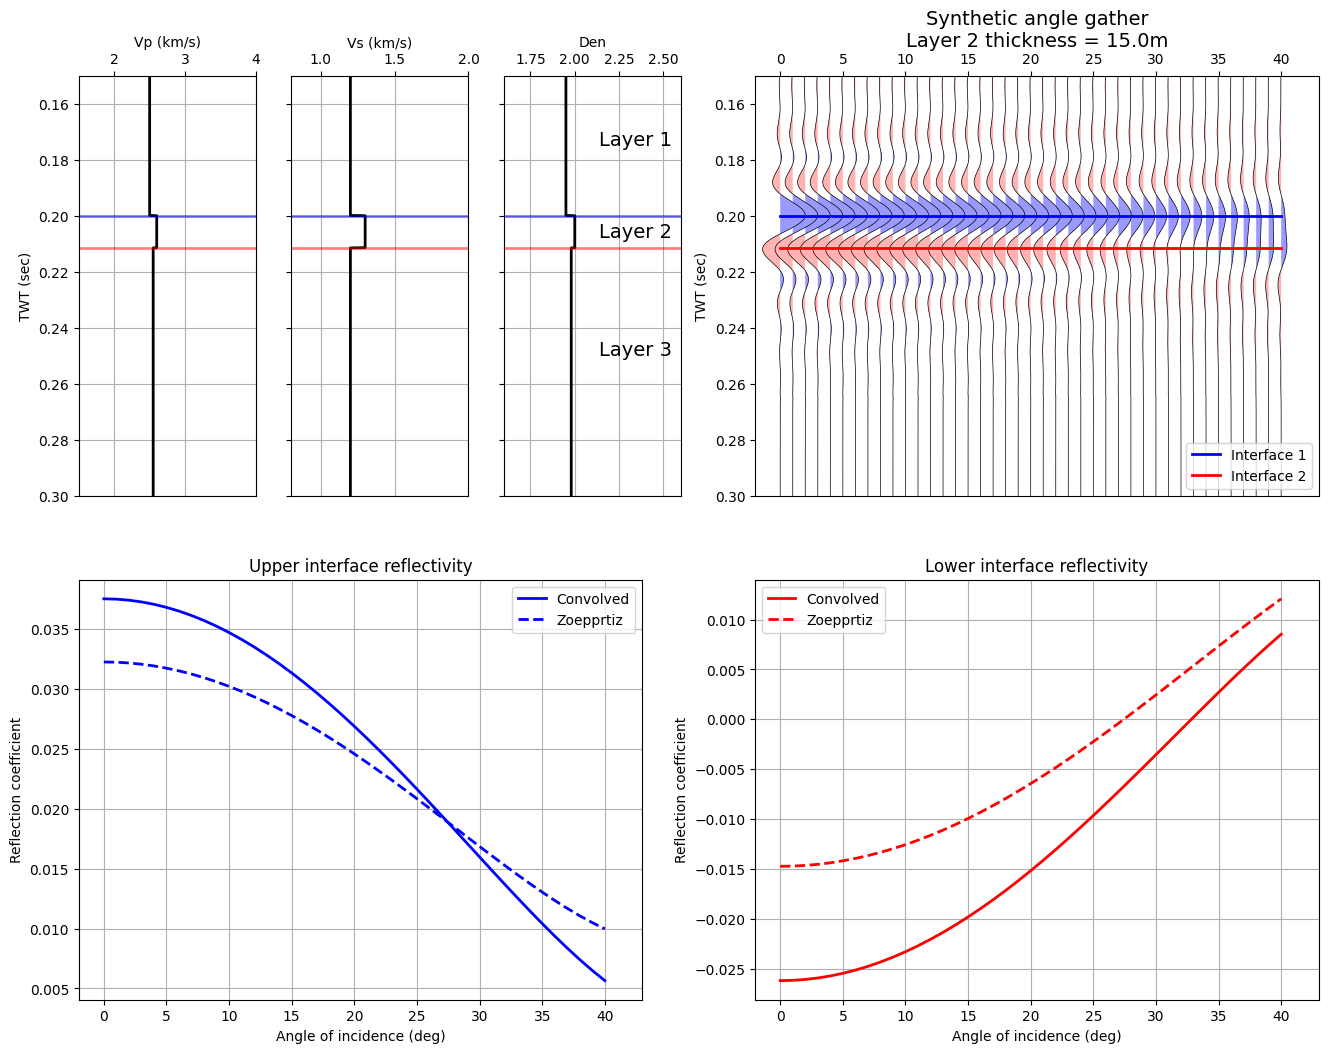

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

from tuning_prestack_v2 import plot_vawig, ricker, wvlt_bpass, calc_times, digitize_model, rc_zoep, ray_param

In [3]:
###########################################################
#
#       DEFINE MODELING PARAMETERS HERE
#


#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [2500.0, 2200.0, 2550.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1200.0, 1200.0]  # S-wave velocity (m/s)
rho_mod= [1.95, 1.8, 1.98]         # Density (g/cc)

thickness = 55.0  # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'bandpass'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = -1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.15
max_plot_time = 0.3
excursion = 2


In [4]:
##########################################################
#
#       COMPUTATIONS HAPPEN BELOW HERE
#


#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0] + dz_app)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])


#   Copy convoved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]] * wvlt_scalar)
    line2.append(syn_zoep_pp[i,lyr2_indx[i]] * wvlt_scalar)



#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

print('\n\n')
print ('  Method       NI         GRAD')
print ('---------------------------------')
print (' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
print (' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):] = vp_mod[2]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):] = vs_mod[2]

rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):] = rho_mod[2]





Starting synthetic calcuations...

Calculated angle 0
Calculated angle 1
Calculated angle 2
Calculated angle 3
Calculated angle 4
Calculated angle 5
Calculated angle 6
Calculated angle 7
Calculated angle 8
Calculated angle 9
Calculated angle 10
Calculated angle 11
Calculated angle 12
Calculated angle 13
Calculated angle 14
Calculated angle 15
Calculated angle 16
Calculated angle 17
Calculated angle 18
Calculated angle 19
Calculated angle 20
Calculated angle 21
Calculated angle 22
Calculated angle 23
Calculated angle 24
Calculated angle 25
Calculated angle 26
Calculated angle 27
Calculated angle 28
Calculated angle 29
Calculated angle 30
Calculated angle 31
Calculated angle 32
Calculated angle 33
Calculated angle 34
Calculated angle 35
Calculated angle 36
Calculated angle 37
Calculated angle 38
Calculated angle 39
Calculated angle 40



  Method       NI         GRAD
---------------------------------
 Zoeppritz   -0.10227    -0.04586
 Convolved  -0.10665    -0.04926


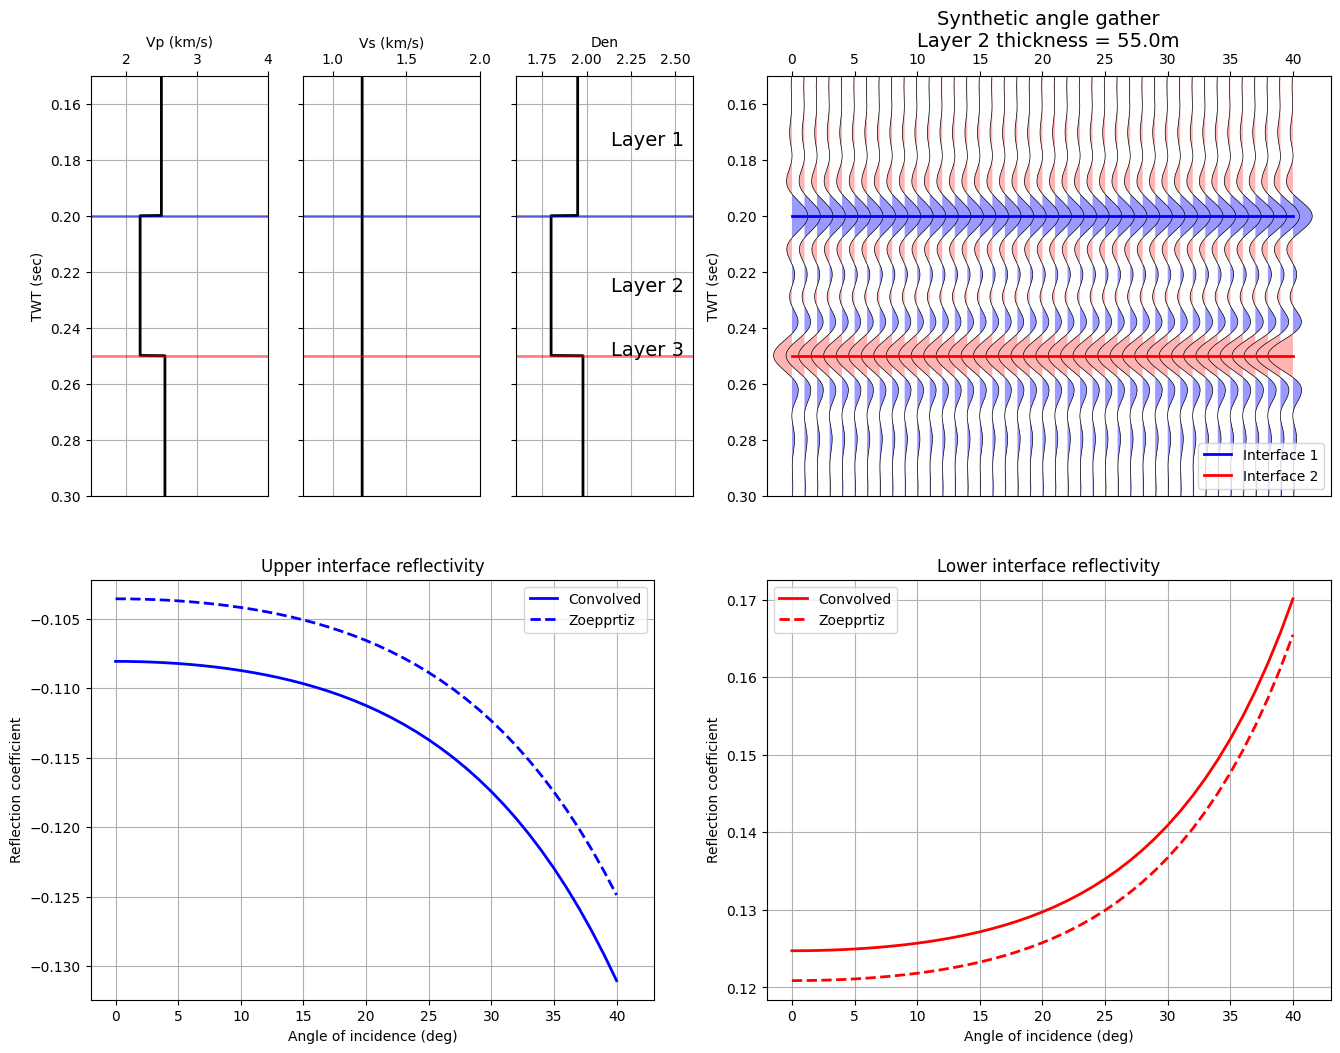

In [5]:
#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(261)
l_vp_dig, = ax0a.plot(vp_dig/1000, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time,max_plot_time))
ax0a.set_xlim(1.5, 4.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('TWT (sec)')
ax0a.xaxis.tick_top()
ax0a.xaxis.set_label_position('top')
ax0a.set_xlabel('Vp (km/s)')
ax0a.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0a.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0a.grid()

ax0b = fig.add_subplot(262)
l_vs_dig, = ax0b.plot(vs_dig/1000, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.set_xlim((0.8, 2.0))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('Vs (km/s)')
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0b.grid()

ax0c = fig.add_subplot(263)
l_rho_dig, = ax0c.plot(rho_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.set_xlim((1.6, 2.6))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel('Den')
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0c.grid()

plt.text(2.55,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        'Layer 2',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=14,
        horizontalalignment='right')

#   Plot synthetic gather and model top & base interfaces in two-way time
ax1 = fig.add_subplot(222)
plot_vawig(ax1, syn_zoep_pp, t, excursion)
ax1.set_ylim((min_plot_time,max_plot_time))
l_int1, = ax1.plot(lyr_times[:,0], color='blue', lw=2)
l_int2, = ax1.plot(lyr_times[:,1], color='red', lw=2)

plt.legend([l_int1,l_int2], ['Interface 1', 'Interface 2'], loc=4)
ax1.invert_yaxis()
label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax1.set_xlabel(label_str, fontsize=14)
ax1.set_ylabel('TWT (sec)')


#   Plot Zoeppritz and convolved reflectivity curves    
ax2 = fig.add_subplot(2,2,3)

l_syn1, = ax2.plot(line1, color='blue', linewidth=2)
l_rc1, = ax2.plot( rc_zoep_pp[:,0], '--', color='blue', lw=2)

ax2.set_xlim((-excursion, ntrc+excursion))
ax2.grid()
ax2.set_xlabel('Angle of incidence (deg)')
ax2.set_ylabel('Reflection coefficient')
ax2.set_title('Upper interface reflectivity')
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax3 = fig.add_subplot(2,2,4)
l_syn2, = ax3.plot(line2, color='red', linewidth=2)
l_rc2, = ax3.plot( rc_zoep_pp[:,1], '--', color='red', lw=2)
ax3.set_xlim((-excursion, ntrc+excursion))
ax3.grid()
ax3.set_xlabel('Angle of incidence (deg)')
ax3.set_ylabel('Reflection coefficient')
ax3.set_title('Lower interface reflectivity')
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)


#   Save the plot
# plt.savefig('figure_2.png')

#   Display the plot
plt.show()
